In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import kornia

import cv2
import numpy as np
import matplotlib.pyplot as plt

In [22]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if False else 'cpu')
print('Using ', device)

Using  cpu


In [23]:
def load_data(filename, device=torch.device('cpu')):
    data_np = np.load(filename)
    data = torch.from_numpy(data_np).to(device)
    return data

def data_to_vis(data):
    return kornia.tensor_to_image(data)

In [24]:
# load the camera matrix
intrinsics_i = load_data('data/depth/camera_intrinsics_0.npy', device)[..., :3, :3]  # 1x3x3
intrinsics_j = load_data('data/depth/camera_intrinsics_1.npy', device)[..., :3, :3]  # 1x3x3
intrinsics_k = load_data('data/depth/camera_intrinsics_2.npy', device)[..., :3, :3]  # 1x3x3

# load the camera pose
i_pose_w = load_data('data/depth/camera_pose_0.npy', device)  # 1x4x4
j_pose_w = load_data('data/depth/camera_pose_1.npy', device)  # 1x4x4
k_pose_w = load_data('data/depth/camera_pose_2.npy', device)  # 1x4x4

# load images
image_i = load_data('data/depth/image_0.npy', device)  # 1x3xHxW
image_j = load_data('data/depth/image_1.npy', device)  # 1x3xHxW
image_k = load_data('data/depth/image_2.npy', device)  # 1x3xHxW

# load the depth map (in meters)
depth_i = load_data('data/depth/depth_0.npy', device)  # 1x1xHxW
depth_j = load_data('data/depth/depth_1.npy', device)  # 1x1xHxW
depth_k = load_data('data/depth/depth_2.npy', device)  # 1x1xHxW

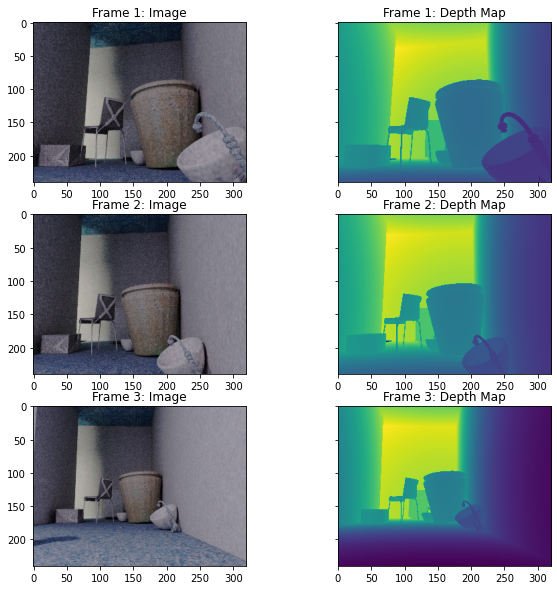

In [25]:
%matplotlib inline
fig, axes = plt.subplots(3, 2, sharey=True)
fig.set_figheight(10)
fig.set_figwidth(10)

axes[0, 0].imshow(data_to_vis(image_i))
axes[0, 0].set_title('Frame 1: Image')

axes[0, 1].imshow(data_to_vis(depth_i))
axes[0, 1].set_title('Frame 1: Depth Map')

axes[1, 0].imshow(data_to_vis(image_j))
axes[1, 0].set_title('Frame 2: Image')

axes[1, 1].imshow(data_to_vis(depth_j))
axes[1, 1].set_title('Frame 2: Depth Map')

axes[2, 0].imshow(data_to_vis(image_k))
axes[2, 0].set_title('Frame 3: Image')

axes[2, 1].imshow(data_to_vis(depth_k))
axes[2, 1].set_title('Frame 3: Depth Map')
plt.show()

In [26]:
# warp by depth
i_trans_j = i_pose_w @ torch.inverse(j_pose_w)
k_trans_j = k_pose_w @ torch.inverse(j_pose_w)
dst_trans_src = torch.cat([i_trans_j, k_trans_j], dim=0)

depth_src = depth_j
intrinsics_src = intrinsics_j.repeat(2,1,1)

image_src = image_j
image_dst = torch.cat([image_i, image_k], dim=0)

image_dst_to_src = kornia.geometry.warp_frame_depth(image_dst, depth_src, dst_trans_src, intrinsics_src)
print(image_dst_to_src.shape)

torch.Size([2, 3, 240, 320])


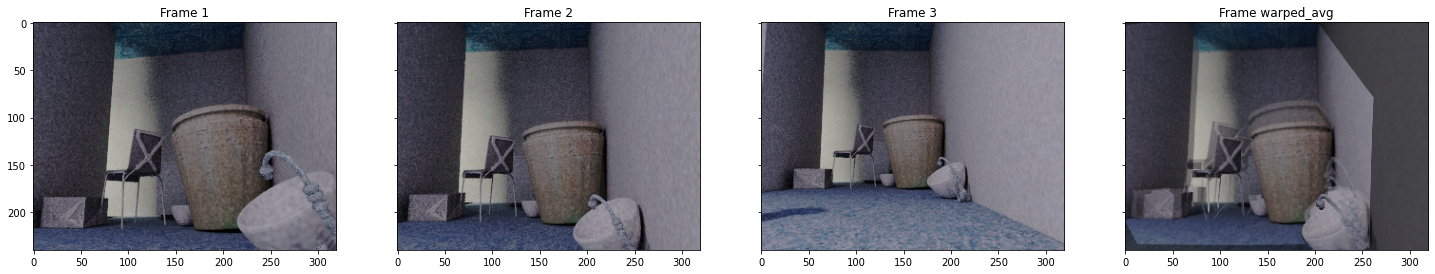

In [27]:
%matplotlib inline
fig, axes = plt.subplots(1, 4, sharey=True)
fig.set_figheight(25)
fig.set_figwidth(25)

axes[0].imshow(data_to_vis(image_i))
axes[0].set_title('Frame 1')

axes[1].imshow(data_to_vis(image_j))
axes[1].set_title('Frame 2')

axes[2].imshow(data_to_vis(image_k))
axes[2].set_title('Frame 3')

axes[3].imshow(data_to_vis(image_dst_to_src.mean(0)))
axes[3].set_title('Frame warped_avg')
plt.show()

Container to hold the depth

In [28]:
class MyDepth(nn.Module):
    def __init__(self, height: int, width: int, max_depth: float = 6.5):
        super(MyDepth, self).__init__()
        self.height = height
        self.width = width
        self.max_depth = max_depth
        
        self.depth: nn.Parameter = nn.Parameter(
            torch.Tensor(1, 1, height, width))
        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.zeros_(self.depth)
        self.depth.data += self.max_depth * torch.rand_like(self.depth)
    
    def scale(self, height: int, width: int):
        # resize previous data
        data_resize: torch.Tensor = F.interpolate(self.depth.data,
            size=(height, width), mode='bilinear', align_corners=True)

        # reallocate depth and copy resized data
        self.depth: nn.Parameter = nn.Parameter(torch.empty_like(data_resize))
        self.depth.data.copy_(data_resize)
        
        # update image params
        self.height = height
        self.width = width

    def forward(self):
        return torch.clamp(self.depth, min=1e-3, max=self.max_depth)  # 1x1xHxW

In [29]:
# create homography parameters
height, width = image_j.shape[-2:]
depth_src_pred = MyDepth(height, width).to(device)

# create optimizer
learning_rate = 1e-3
optimizer = optim.Adam(depth_src_pred.parameters(), lr=learning_rate)

In [30]:
def scale_intrinsics(intrinsics, scale_factor):
    intrinsics_scale = intrinsics.clone()
    intrinsics_scale[..., 0, 0] *= scale_factor
    intrinsics_scale[..., 1, 1] *= scale_factor
    intrinsics_scale[..., 0, 2] *= scale_factor
    intrinsics_scale[..., 1, 2] *= scale_factor
    return intrinsics_scale

def compute_scale_factor(image_src, image_dst):
    assert len(image_src.shape) == len(image_dst.shape)
    width_src = image_src.shape[3]
    width_dst = image_dst.shape[3]
    return float(width_dst) / width_src

In [31]:
# compute the gaussian pyramids
num_levels = 4
image_src_pyr = kornia.geometry.build_pyramid(image_src, num_levels)
image_dst_pyr = kornia.geometry.build_pyramid(image_dst, num_levels)

In [32]:
num_iterations = 1000
error_tol = 1e-8

def compute_scale_loss(image_dst: torch.Tensor,
                       image_src: torch.Tensor,
                       depth_src: nn.Module,
                       dst_trans_src: torch.Tensor,
                       intrinsics_src: torch.Tensor,
                       optimizer: torch.optim,
                       num_iterations: int,
                       error_tol: float) -> torch.Tensor:
    for iter_idx in range(num_iterations):
            # warp by the depth
            depth_src_tmp: torch.Tensor = depth_src()

            image_dst_to_src = kornia.geometry.warp_frame_depth(
                image_dst, depth_src_tmp, dst_trans_src, intrinsics_src)

            ones = kornia.geometry.warp_frame_depth(torch.ones_like(image_dst),
                depth_src_tmp, dst_trans_src, intrinsics_src).mean(0)

            # compute and mask loss
            image_src = image_src.expand(image_dst.shape[0], -1, -1, -1)

            loss_rep = F.l1_loss(image_dst_to_src, image_src, reduction='none') # 1x3xHxW
            loss_rep = loss_rep.mean()
            
            idepth = 1. / (depth_src_tmp + 1e-8)
            loss_smooth = kornia.losses.inverse_depth_smoothness_loss(idepth, image_src)
            
            lambda1 = 0.75
            loss = loss_rep + lambda1 * loss_smooth
            
            # compute gradient and update optimizer parameters
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if iter_idx % 500 == 0:
                print(loss_rep)
                print(loss_smooth)
                print('=========')

Scale 3
tensor(0.1006, grad_fn=<MeanBackward0>)
tensor(0.4331, grad_fn=<AddBackward0>)
tensor(0.0888, grad_fn=<MeanBackward0>)
tensor(0.2413, grad_fn=<AddBackward0>)
Train iteration: 0/4


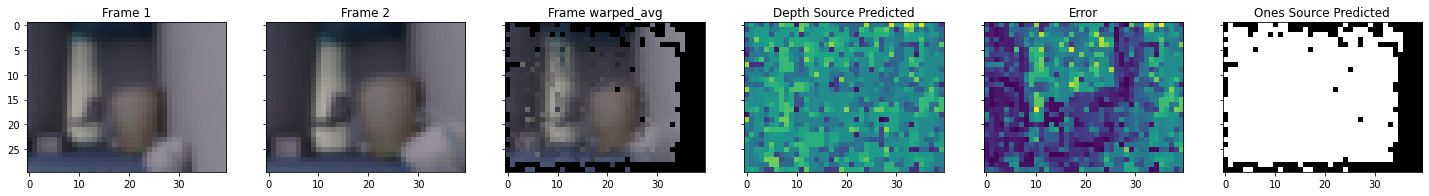

Scale 2
tensor(0.0841, grad_fn=<MeanBackward0>)
tensor(0.0512, grad_fn=<AddBackward0>)
tensor(0.0722, grad_fn=<MeanBackward0>)
tensor(0.0262, grad_fn=<AddBackward0>)
Train iteration: 1/4


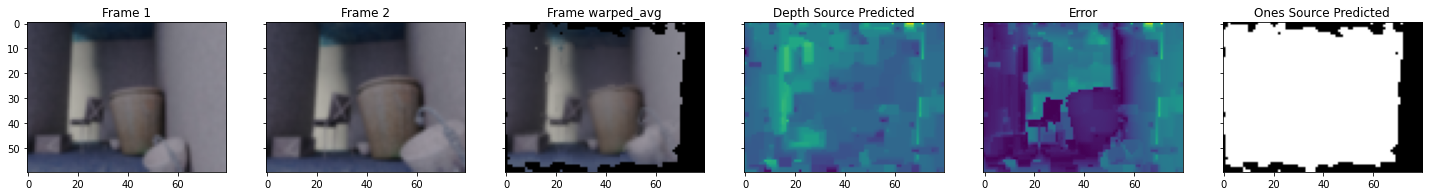

Scale 1
tensor(0.0732, grad_fn=<MeanBackward0>)
tensor(0.0083, grad_fn=<AddBackward0>)
tensor(0.0661, grad_fn=<MeanBackward0>)
tensor(0.0079, grad_fn=<AddBackward0>)
Train iteration: 2/4


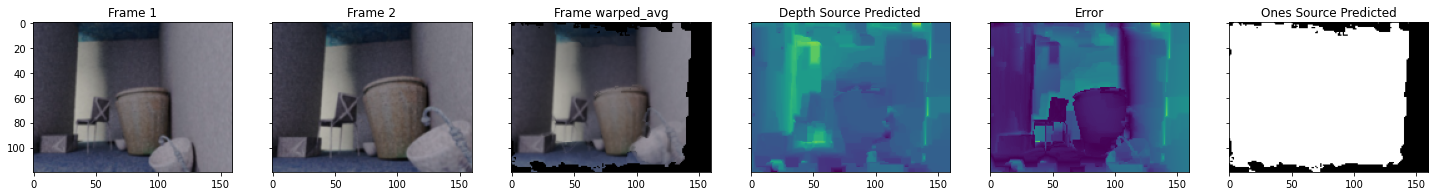

Scale 0
tensor(0.0765, grad_fn=<MeanBackward0>)
tensor(0.0038, grad_fn=<AddBackward0>)
tensor(0.0696, grad_fn=<MeanBackward0>)
tensor(0.0062, grad_fn=<AddBackward0>)
Train iteration: 3/4


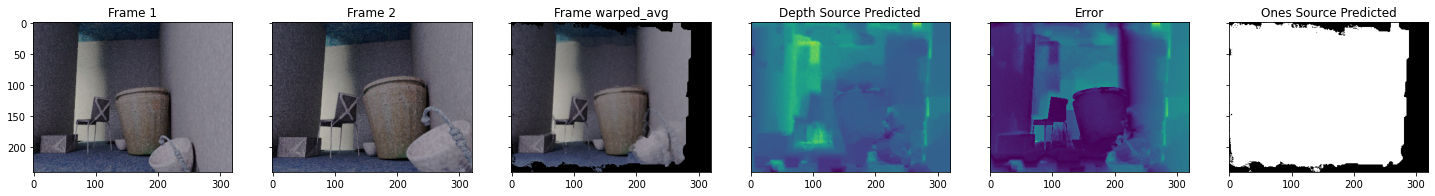

In [33]:
# pyramid loop

for iter_idx in range(num_levels):
    
    # get current pyramid data
    scale = (num_levels - 1) - iter_idx
    image_src_scale = image_src_pyr[scale]
    image_dst_scale = image_dst_pyr[scale]
    print("Scale {}".format(scale))
    
    scale_factor: float = compute_scale_factor(
        image_src, image_src_scale)

    intrinsics_src_scale: torch.Tensor = scale_intrinsics(
        intrinsics_src, scale_factor)
    
    # scale the depth map
    height_scale: int = image_src_scale.shape[2]
    width_scale: int = image_src_scale.shape[3]
    depth_src_pred.scale(height_scale, width_scale)
    
    _lr = learning_rate
    optimizer = optim.Adam(depth_src_pred.parameters(), lr=_lr)

    # compute scale loss
    compute_scale_loss(image_dst_scale, image_src_scale, depth_src_pred,
                       dst_trans_src, intrinsics_src_scale, optimizer,
                       num_iterations, error_tol)

    print('Train iteration: {}/{}'.format(iter_idx, num_levels))
    
    image_dst_to_src = kornia.geometry.warp_frame_depth(
        image_dst_scale, depth_src_pred(), dst_trans_src, intrinsics_src_scale)
    
    ones = kornia.geometry.warp_frame_depth(
        torch.ones_like(image_dst_scale), depth_src_pred(), dst_trans_src, intrinsics_src_scale)
    ones = (ones.mean(0) > 0.95).float()
    
    depth_src_scale_gt = F.interpolate(depth_src, size=(height_scale, width_scale))
    #image_dst_to_src_gt = warp_frame_depth(
    #    image_dst_scale, depth_src_scale, dst_trans_src, intrinsics_src_scale)

    %matplotlib inline
    fig, axes = plt.subplots(1, 6, sharey=True)
    fig.set_figheight(25)
    fig.set_figwidth(25)

    axes[0].imshow(data_to_vis(image_src_scale[0]))
    axes[0].set_title('Frame 1')

    axes[1].imshow(data_to_vis(image_dst_scale[0]))
    axes[1].set_title('Frame 2')

    axes[2].imshow(data_to_vis((image_dst_to_src*ones).mean(0)))
    axes[2].set_title('Frame warped_avg')

    axes[3].imshow(data_to_vis(depth_src_pred()))
    axes[3].set_title('Depth Source Predicted')

    axes[4].imshow(data_to_vis(torch.abs(depth_src_scale_gt-depth_src_pred()).mean(0)))
    axes[4].set_title('Error')
    
    axes[5].imshow(data_to_vis(ones))
    axes[5].set_title('Ones Source Predicted')
    
    plt.show()